In [ ]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# label = 'focal'
label = 'dnn_regressor_64_32_32_8_1'
grulabel = ''

loss_fn = "mse"
learningRate = 1e-3
nEpochs = 25
batchSize = 64

In [2]:
def load_data(dir, files):
    # Dictionary to store lists of arrays for each key
    combined_data = {}

    # Loop through files and collect arrays
    for filename in files:
        origdata = np.load(dir+filename)
        for key in origdata.files:
            if key not in combined_data:
                combined_data[key] = []
            combined_data[key].append(origdata[key])

    # Concatenate arrays along the first axis for each key
    return {key: np.concatenate(arr_list, axis=0) for key, arr_list in combined_data.items()}


In [ ]:
data = load_data("./processed_data_train/",
                 ["batch_0.npz",
                  "batch_1.npz",
                  "batch_2.npz",
                  "batch_3.npz",
                  "batch_4.npz",
                 ])
# data = {d:data[d][:1000] for d in data} # reduce size in memory

In [3]:
testdata = load_data("./processed_data_test/",
                     ["batch_0.npz",
                      # "batch_1.npz",
                      # "batch_2.npz",
                      # "batch_3.npz",
                      # "batch_4.npz",
                    ])

In [14]:
print(data['wf_i'].shape)
print(data['mom'].shape)
print(data['tag_times'].shape)
print(data['tag_values'].shape)

(100000, 3000)
(100000,)
(100000, 300)
(100000, 300)


In [4]:
def expand_values(values, times, tlength=3000, ohe=True, combine=False):
    # values: (300,)
    # times: (300,)
    data = np.zeros((tlength,), dtype=np.float32)

    # Place values at the correct times
    valid_mask = (times >= 0) & (times < tlength)
    times = times[valid_mask]
    values = values[valid_mask]

    data[times] = values

    if ohe:
        ohe_data = np.zeros((tlength, 3), dtype=np.float32)
        for i in range(3):
            ohe_data[:, i] = (data == i).astype(np.float32)
        if combine:
            ohe_data[:, 1] = np.any(ohe_data[:, 1:], axis=-1)
            ohe_data[:, 2] = 0.0
        return ohe_data
    else:
        if combine:
            data = (data > 0).astype(np.float32)
        return data[:, None]  # shape (3000, 1)
    
def np_expand_values(values,times,tlength = 3000, ohe = True, combine = False):
    data = np.zeros((values.shape[0],tlength))
    data[np.arange(times.shape[0])[:,None],times] = values
    if ohe:
        data = np.concatenate([(data==i)[:,:,None] for i in range(3)],axis=-1).astype(np.float32)
        if combine:
            data[:,:,1] = np.any(data[:,:,1:],axis=-1)
            data[:,:,2] = 0.
    else:
        if combine:
            data = (data>0).astype(np.float32)
    return data

def batched_expand_values(values, times, batch_size=1000, tlength=3000, ohe=True, combine=False):
    outputs = []
    for i in tqdm(range(0, len(values), batch_size)):
        v_batch = values[i:i+batch_size]
        t_batch = times[i:i+batch_size]
        out = np_expand_values(v_batch, t_batch, tlength=tlength, ohe=ohe, combine=combine)
        outputs.append(out)
    return np.concatenate(outputs, axis=0)

In [5]:
import tensorflow as tf
from tensorflow import keras
# Import tf/keras modules
from keras.layers import Dense
from keras.layers import Input
# This clears the Keras session
tf.keras.backend.clear_session()

In [15]:
import os, sys

def load_npz_individual(file_path_bytes):
    path = file_path_bytes.decode("utf-8")
    data = np.load(path)
    wf_i = data["wf_i"].astype(np.float32)        # (N, 3000)
    tag_values = data["tag_values"]               # (N, ?)
    tag_times = data["tag_times"]                 # (N, ?)
    return wf_i, tag_values, tag_times

def extract_regression_targets(tag_values, tag_times, tlength=3000, single_output=False):
    """
    Extract regression targets from tag data
    
    Returns:
        If single_output=True: returns count_ones (scalar)
        If single_output=False: returns np.array([count_nonzero, count_ones])
    """
    valid_mask = (tag_times >= 0) & (tag_times < tlength)
    valid_values = tag_values[valid_mask]
    
    count_ones = np.sum(valid_values == 1).astype(np.float32)
    
    if single_output:
        return count_ones
    else:
        count_nonzero = np.sum(valid_values > 0).astype(np.float32)
        return np.array([count_nonzero, count_ones], dtype=np.float32)

def build_dataset(file_list, batch_size, tlength=3000, ohe=True, combine=False, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices(file_list)

    def file_to_dataset(file_path):
        wf_i, tag_values, tag_times = tf.numpy_function(
            func=load_npz_individual,
            inp=[file_path],
            Tout=[tf.float32, tf.int32, tf.int32]
        )
        # Shapes are unknown, need to set
        wf_i.set_shape([None, tlength])         # (N, 3000)
        tag_values.set_shape([None, 300])      # (N, ?)
        tag_times.set_shape([None, 300])       # (N, ?)

        ex_ds = tf.data.Dataset.from_tensor_slices((wf_i, tag_values, tag_times))

        def process(wf_i_ex, tag_values_ex, tag_times_ex):
            wf_i_ex = tf.expand_dims(wf_i_ex, axis=-1)  # (3000, 1)
            y = tf.numpy_function(
                func=lambda v, t: expand_values(v, t, tlength, ohe, combine),
                inp=[tag_values_ex, tag_times_ex],
                Tout=tf.float32
            )
            wf_i_ex.set_shape([tlength, 1])
            y.set_shape([tlength, 3])
            return wf_i_ex, y

        return ex_ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)

    #if shuffle:
    #    ds = ds.shuffle(len(file_list))

    ds = ds.flat_map(file_to_dataset)
    ds = ds.shuffle(512)  # shuffle individual examples
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

def build_regression_dataset(file_list, batch_size, tlength=3000, shuffle=True, single_output=False):
    """
    Build regression dataset from file list
    
    Args:
        file_list: List of file paths
        batch_size: Batch size for training
        tlength: Time series length, default 3000
        shuffle: Whether to shuffle the dataset
        single_output: If True, return single target (count_ones); if False, return dual targets
    
    Returns:
        TensorFlow dataset with appropriate target shape
    """
    ds = tf.data.Dataset.from_tensor_slices(file_list)

    def file_to_dataset(file_path):
        wf_i, tag_values, tag_times = tf.numpy_function(
            func=load_npz_individual,
            inp=[file_path],
            Tout=[tf.float32, tf.int32, tf.int32]
        )
        
        wf_i.set_shape([None, tlength])
        tag_values.set_shape([None, 300])
        tag_times.set_shape([None, 300])

        ex_ds = tf.data.Dataset.from_tensor_slices((wf_i, tag_values, tag_times))

        def process(wf_i_ex, tag_values_ex, tag_times_ex):
            wf_i_ex = tf.expand_dims(wf_i_ex, axis=-1)
            
            y = tf.numpy_function(
                func=lambda v, t: extract_regression_targets(v, t, tlength, single_output=single_output),
                inp=[tag_values_ex, tag_times_ex],
                Tout=tf.float32
            )
            
            wf_i_ex.set_shape([tlength, 1])
            
            # Set target shape based on output type
            if single_output:
                y.set_shape([])
            else:
                y.set_shape([2])
            
            return wf_i_ex, y

        return ex_ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.flat_map(file_to_dataset)
    if shuffle:
        ds = ds.shuffle(512)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [7]:
from sklearn.model_selection import train_test_split
import glob

# Load file paths
file_list = sorted(glob.glob("./processed_data_train/*.npz"))
train_files, val_files = train_test_split(file_list, test_size=0.2, shuffle=True)

train_ds = build_regression_dataset(train_files, batchSize, single_output=True)
val_ds = build_regression_dataset(val_files, batchSize, shuffle=False, single_output=True)

for x_batch, y_batch in train_ds.take(1):
    print(f"Input shape: {x_batch.shape}") 
    print(f"Output shape: {y_batch.shape}")
    print(f"Sample targets: {y_batch[0]}")
    break

Input shape: (64, 3000, 1)
Output shape: (64,)
Sample targets: 19.0


In [17]:
from keras.layers import Conv1D, MaxPooling1D, Dense, Input, Flatten, GlobalAveragePooling1D, GRU, Reshape, Conv1DTranspose, UpSampling1D
 
def dndx_gru(c1layers=[[32,1,1,'valid',False]],
             rlayers=[32],
             c2layers=[],#[[32,1,1,'valid'],[32,1,1,'valid']],
             dlayers=[32,32]):
    # inputs = Input(shape=(data['wf_i'].shape[1],1))
    inputs = Input(shape=(data['wf_i'].shape[1],))
    x = inputs
    npool = 0
    for i,c in enumerate(c1layers):
        x = Conv1D(c[0],c[1],c[2],padding=c[3],activation="relu")(x)
        # if i == 0:
        #     x = MaxPooling1D(2)(x)
        #     npool = npool+1
    for i,r in enumerate(rlayers):
        x = GRU(r,
                activation="tanh",
                recurrent_activation="sigmoid",
                return_sequences=True,
              )(x)
    # for i,c in enumerate(c2layers):
    #     x = Conv1DTranspose((1 if i<len(c2layers)-1 or npool==0 else 2*npool)*c[0],c[1],c[2],padding=c[3],activation="relu")(x)
    #     if i==len(c2layers)-1 and npool>0:
    #         x = Reshape((-1,c))(x)
 
    # x = UpSampling1D(size = 5)(x)
    # x = Conv1D(16,5,1,padding='same',activation="relu")(x)
    # x = GlobalAveragePooling1D()(x)
    
    for i,d in enumerate(dlayers):
        x = Dense(d,activation="relu")(x)
        # if i == 1:
        #     x = GlobalAveragePooling1D()(x)
    # x = Reshape((3000,-1))(x)
    outputs = Dense(1,activation='relu')(x)
    
    return keras.Model(inputs=inputs, outputs=outputs, name="gru")

# gru_c1layers=[[16,5,5,'valid',False],[16,5,1,'same',False]]
# gru_c1layers=[[16,5,5,'valid',False],[16,5,1,'same',False],[16,5,1,'same',False]]
gru_c1layers=[]
gru_rlayers=[]
gru_c2layers=[]
#gru_c2layers=[[32,1,1,'valid'],[32,1,1,'valid']]
gru_dlayers=[64,32,32,8]
doGRUTrain = False

dndxgru = dndx_gru(gru_c1layers, gru_rlayers, gru_c2layers, gru_dlayers)

print(dndxgru.summary())

Model: "gru"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 3000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │       192,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 195,473 (763.57 KB)

 Trainable params: 195,473 (763.57 KB)

 Non-trainable params: 0 (0.00 B)

None


In [18]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.optimizers import Adam

earlystop = EarlyStopping(
        monitor="val_loss", 
        patience=10,
        restore_best_weights=True,
        min_delta=0.0, 
    )

reducelr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=5,
    min_delta=0.,
    min_lr=1.e-7,
)

dndxgru = dndx_gru(gru_c1layers,gru_rlayers,gru_c2layers,gru_dlayers)

print(dndxgru.summary())
# Define Optimizer and compile

# Use subset of data for trial run
USE_SUBSET = False
SUBSET_FRACTION = 0.25


opt = Adam(learning_rate=learningRate)
dndxgru.compile(loss='mse', optimizer=opt,
    metrics=["mae"])

if doGRUTrain:
    if USE_SUBSET:
        print(f"Using {SUBSET_FRACTION*100}% of data for trial run ...")
        subset_train_files = train_files[:int(len(train_files) * SUBSET_FRACTION)]
        subset_val_files = val_files[:int(len(val_files) * SUBSET_FRACTION)]
    
        train_ds_subset = build_regression_dataset(subset_train_files, batchSize, shuffle=True)
        val_ds_subset = build_regression_dataset(subset_val_files, batchSize, shuffle=False)

        history = dndxgru.fit(train_ds_subset, validation_data=val_ds_subset,
                      epochs=nEpochs, callbacks=(earlystop,reducelr))
        
        model_name = f'models/dndxgru_{label+grulabel}_subset{int(SUBSET_FRACTION*100)}.keras'
    else:
        print(f"Using full data for training ...")
        history = dndxgru.fit(train_ds, validation_data=val_ds,
                      epochs=nEpochs, callbacks=(earlystop,reducelr))
        model_name = f'models/dndxgru_{label+grulabel}.keras'

    dndxgru.save(model_name)
else:
    dndxgru = keras.models.load_model('models/dndxgru_%s.keras'%(label+grulabel))

Model: "gru"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 3000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │       192,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 195,473 (763.57 KB)

 Trainable params: 195,473 (763.57 KB)

 Non-trainable params: 0 (0.00 B)

None


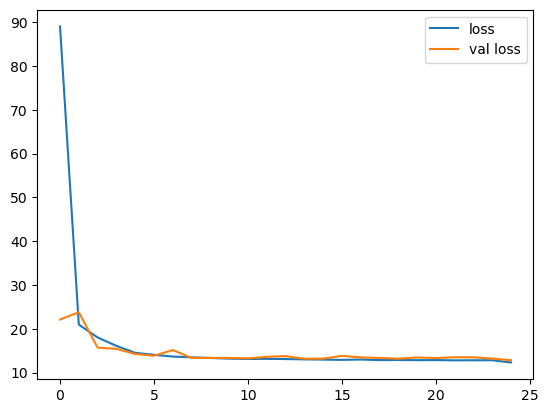

In [13]:
if doGRUTrain:
    plt.plot(history.history['loss'],label='loss')
    plt.plot(history.history['val_loss'],label='val loss')
    plt.legend()

In [19]:
rawgrupreds = dndxgru.predict(testdata['wf_i'])
print(rawgrupreds.shape)
print(rawgrupreds[0])

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 270us/step
(100000, 1)
[25.271358]


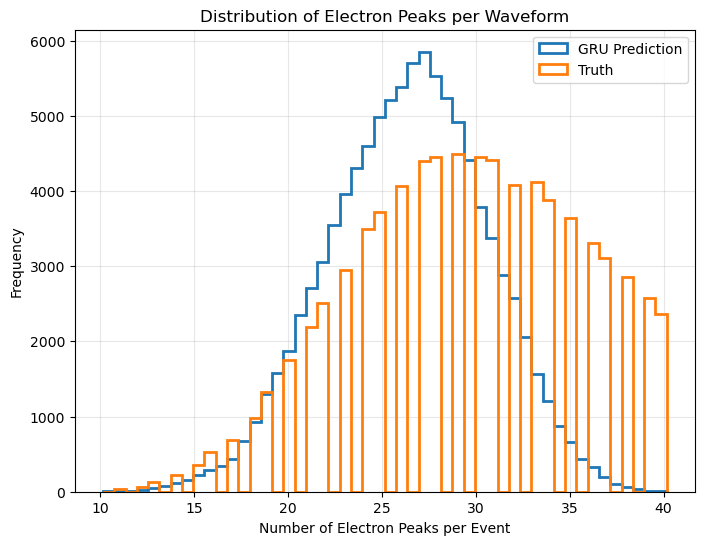

IndexError: index 1 is out of bounds for axis 1 with size 1

<Figure size 800x600 with 0 Axes>

In [15]:
ntest = len(rawgrupreds)

truth_labels = []
for i in range(ntest):
    truth = extract_regression_targets(testdata['tag_values'][i], testdata['tag_times'][i])
    truth_labels.append(truth)
truth_labels = np.array(truth_labels)  


plt.figure(figsize=(8, 6))
_, bins1, _ = plt.hist(rawgrupreds[:, 0], bins=50, 
                      histtype='step', label='GRU Prediction', linewidth=2)
plt.hist(truth_labels[:, 0], bins=bins1, histtype='step', 
         label='Truth', linewidth=2)
plt.legend()
plt.title('Distribution of Electron Peaks per Waveform')
plt.xlabel('Number of Electron Peaks per Event')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(8, 6))
_, bins2, _ = plt.hist(rawgrupreds[:, 1], bins=15, 
                      histtype='step', label='GRU Prediction', linewidth=2)
plt.hist(truth_labels[:, 1], bins=bins2, histtype='step', 
         label='Truth', linewidth=2)
plt.legend()
plt.title('Distribution of Primary Ionizations per Waveform')
plt.xlabel('Number of Primary Ionizations per Event')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

predicted_electron_peak_counts = rawgrupreds[:, 0]
predicted_primary_peak_counts = rawgrupreds[:, 1]

true_electron_peak_counts = truth_labels[:, 0]
true_primary_peak_counts = truth_labels[:, 1]



mask = true_primary_peak_counts > 0
relative_error = (predicted_primary_peak_counts[mask] - true_primary_peak_counts[mask]) / true_primary_peak_counts[mask]
diff = predicted_primary_peak_counts - true_primary_peak_counts
correlation = np.corrcoef(true_primary_peak_counts, predicted_primary_peak_counts)[0, 1]

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
max_val = max(np.max(true_primary_peak_counts), np.max(predicted_primary_peak_counts))
bins = np.linspace(0, max_val, 50)
plt.hist2d(true_primary_peak_counts, predicted_primary_peak_counts, bins=[bins, bins], 
           cmap='Blues', alpha=0.8)
plt.colorbar(label='Count')
plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.8, linewidth=2, label='y = x')
plt.xlabel('True Primary Peak Count')
plt.ylabel('Estimated Primary Peak Count')
plt.title('Estimated vs. True Primary Peaks')
plt.grid(True, alpha=0.3)
plt.legend()
plt.axis('equal')

plt.subplot(2, 2, 2)
plt.scatter(true_primary_peak_counts[mask], relative_error, alpha=0.6, s=20, color='blue')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.8)
plt.xlabel('True Primary Peak Count')
plt.ylabel('Relative Error: (Est - True)/True')
plt.title('Relative Error vs. True Count')
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.hist(relative_error, bins=60, alpha=0.7, edgecolor='black', color='purple')
plt.axvline(x=0, color='r', linestyle='--', alpha=0.8)
plt.axvline(x=np.mean(relative_error), color='orange', linestyle='-', alpha=0.8,
            label=f'Mean: {np.mean(relative_error):.3f} / Std: {np.std(relative_error):.3f}')
plt.xlabel('Relative Error: (Estimated - True) / True')
plt.ylabel('Frequency')
plt.title('Distribution of Relative Errors')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

print(f"Correlation: {correlation:.3f}")
print(f"Mean difference (estimated - true): {np.mean(diff):.2f}")
print(f"Standard deviation of differences: {np.std(diff):.2f}")
print(f"Mean relative error: {np.mean(relative_error):.3f}")
print(f"Std relative error: {np.std(relative_error):.3f}")
print(f"Median relative error: {np.median(relative_error):.3f}")
print(f"Events with zero true peaks excluded: {np.sum(mask)} / {len(true_primary_peak_counts)}")




mask = true_electron_peak_counts > 0
relative_error = (predicted_electron_peak_counts[mask] - true_electron_peak_counts[mask]) / true_electron_peak_counts[mask]
diff = predicted_electron_peak_counts - true_electron_peak_counts
correlation = np.corrcoef(true_electron_peak_counts, predicted_electron_peak_counts)[0, 1]

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
max_val = max(np.max(true_electron_peak_counts), np.max(predicted_electron_peak_counts))
bins = np.linspace(0, max_val, 50)
plt.hist2d(true_electron_peak_counts, predicted_electron_peak_counts, bins=[bins, bins], 
           cmap='Greens', alpha=0.8)
plt.colorbar(label='Count')
plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.8, linewidth=2, label='y = x')
plt.xlabel('True Electron Peak Count')
plt.ylabel('Estimated Electron Peak Count')
plt.title('Estimated vs. True Electron Peaks')
plt.grid(True, alpha=0.3)
plt.legend()
plt.axis('equal')

plt.subplot(2, 2, 2)
plt.scatter(true_electron_peak_counts[mask], relative_error, alpha=0.6, s=20, color='blue')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.8)
plt.xlabel('True Primary Peak Count')
plt.ylabel('Relative Error: (Est - True)/True')
plt.title('Relative Error vs. True Count')
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.hist(relative_error, bins=60, alpha=0.7, edgecolor='black', color='purple')
plt.axvline(x=0, color='r', linestyle='--', alpha=0.8)
plt.axvline(x=np.mean(relative_error), color='orange', linestyle='-', alpha=0.8,
            label=f'Mean: {np.mean(relative_error):.3f} / Std: {np.std(relative_error):.3f}')
plt.xlabel('Relative Error: (Estimated - True) / True')
plt.ylabel('Frequency')
plt.title('Distribution of Relative Errors')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

print(f"Correlation: {correlation:.3f}")
print(f"Mean difference (estimated - true): {np.mean(diff):.2f}")
print(f"Standard deviation of differences: {np.std(diff):.2f}")
print(f"Mean relative error: {np.mean(relative_error):.3f}")
print(f"Std relative error: {np.std(relative_error):.3f}")
print(f"Median relative error: {np.median(relative_error):.3f}")
print(f"Events with zero true peaks excluded: {np.sum(mask)} / {len(true_primary_peak_counts)}")

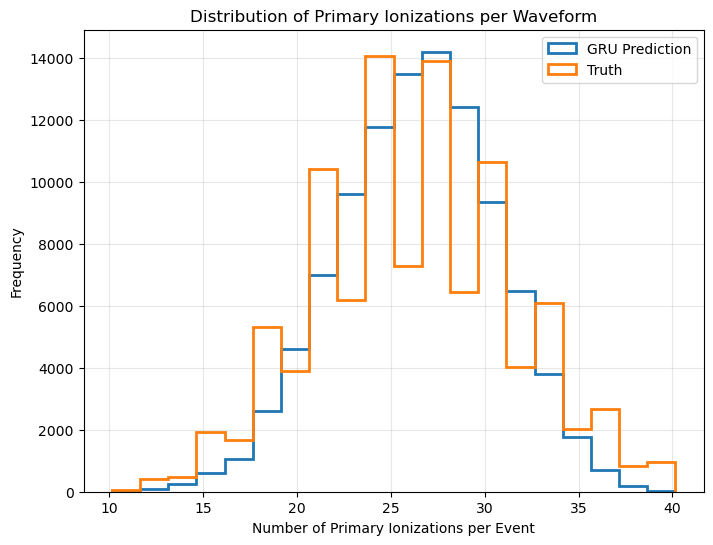

In [16]:
ntest = len(rawgrupreds)

truth_labels = []
for i in range(ntest):
    truth = extract_regression_targets(testdata['tag_values'][i], testdata['tag_times'][i])
    truth_labels.append(truth)
truth_labels = np.array(truth_labels)  

plt.figure(figsize=(8, 6))
_, bins2, _ = plt.hist(rawgrupreds[:, 0], bins=20, 
                      histtype='step', label='GRU Prediction', linewidth=2)
plt.hist(truth_labels[:, 1], bins=bins2, histtype='step', 
         label='Truth', linewidth=2)
plt.legend()
plt.title('Distribution of Primary Ionizations per Waveform')
plt.xlabel('Number of Primary Ionizations per Event')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

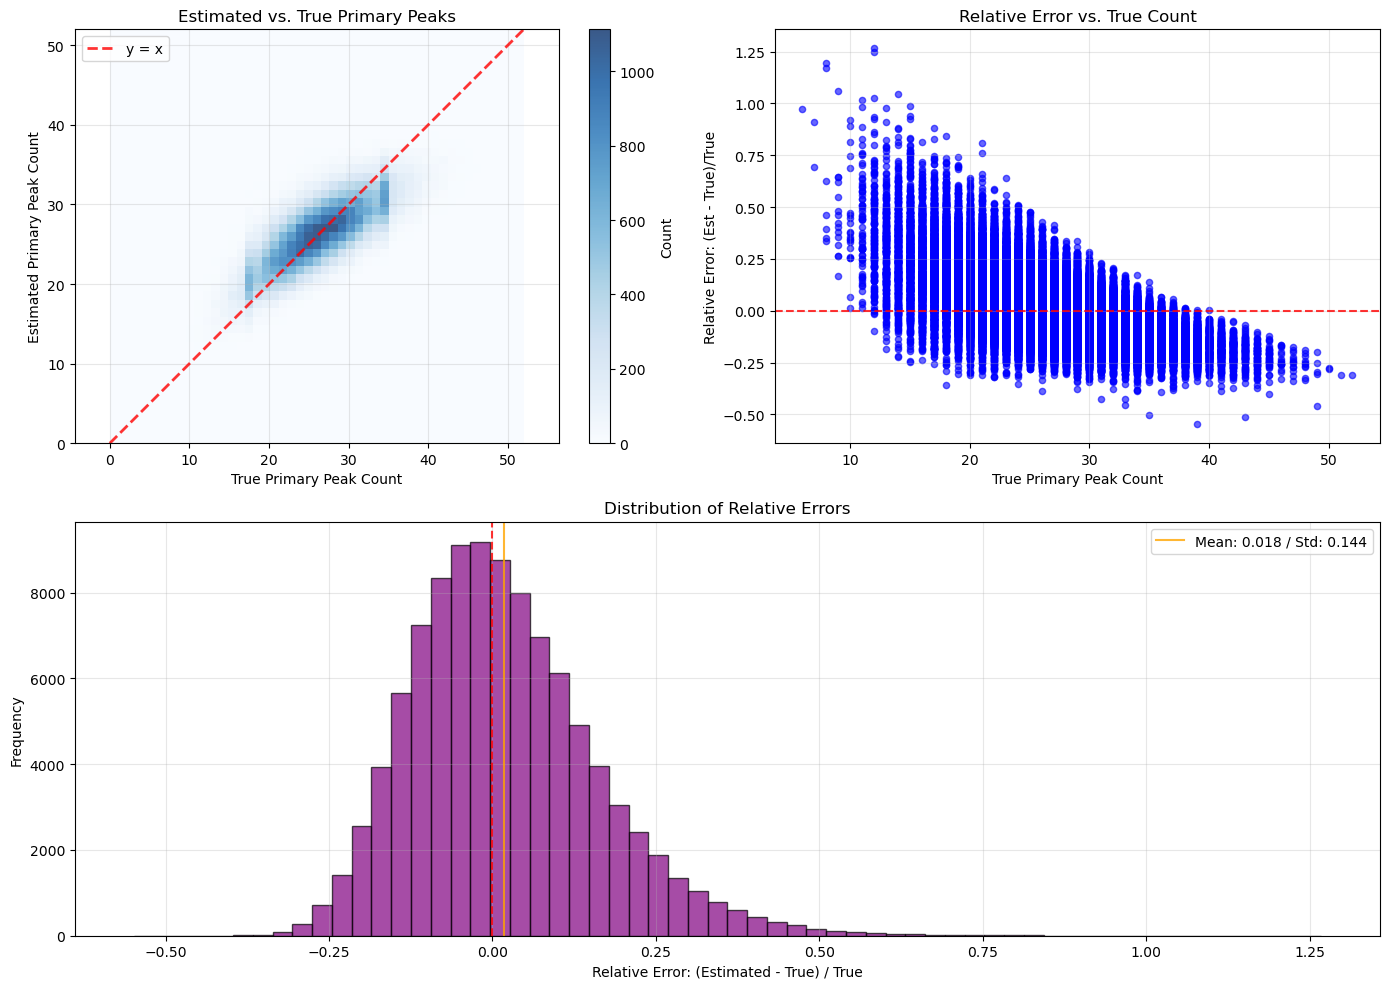

Correlation: 0.755
Mean difference (estimated - true): -0.02
Standard deviation of differences: 3.57
Mean relative error: 0.018
Std relative error: 0.144
Median relative error: 0.001
Events with zero true peaks excluded: 100000 / 100000


In [17]:
predicted_primary_peak_counts = rawgrupreds[:, 0]
true_primary_peak_counts = truth_labels[:, 1]



mask = true_primary_peak_counts > 0
relative_error = (predicted_primary_peak_counts[mask] - true_primary_peak_counts[mask]) / true_primary_peak_counts[mask]
diff = predicted_primary_peak_counts - true_primary_peak_counts
correlation = np.corrcoef(true_primary_peak_counts, predicted_primary_peak_counts)[0, 1]

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
max_val = max(np.max(true_primary_peak_counts), np.max(predicted_primary_peak_counts))
bins = np.linspace(0, max_val, 50)
plt.hist2d(true_primary_peak_counts, predicted_primary_peak_counts, bins=[bins, bins], 
           cmap='Blues', alpha=0.8)
plt.colorbar(label='Count')
plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.8, linewidth=2, label='y = x')
plt.xlabel('True Primary Peak Count')
plt.ylabel('Estimated Primary Peak Count')
plt.title('Estimated vs. True Primary Peaks')
plt.grid(True, alpha=0.3)
plt.legend()
plt.axis('equal')

plt.subplot(2, 2, 2)
plt.scatter(true_primary_peak_counts[mask], relative_error, alpha=0.6, s=20, color='blue')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.8)
plt.xlabel('True Primary Peak Count')
plt.ylabel('Relative Error: (Est - True)/True')
plt.title('Relative Error vs. True Count')
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.hist(relative_error, bins=60, alpha=0.7, edgecolor='black', color='purple')
plt.axvline(x=0, color='r', linestyle='--', alpha=0.8)
plt.axvline(x=np.mean(relative_error), color='orange', linestyle='-', alpha=0.8,
            label=f'Mean: {np.mean(relative_error):.3f} / Std: {np.std(relative_error):.3f}')
plt.xlabel('Relative Error: (Estimated - True) / True')
plt.ylabel('Frequency')
plt.title('Distribution of Relative Errors')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

print(f"Correlation: {correlation:.3f}")
print(f"Mean difference (estimated - true): {np.mean(diff):.2f}")
print(f"Standard deviation of differences: {np.std(diff):.2f}")
print(f"Mean relative error: {np.mean(relative_error):.3f}")
print(f"Std relative error: {np.std(relative_error):.3f}")
print(f"Median relative error: {np.median(relative_error):.3f}")
print(f"Events with zero true peaks excluded: {np.sum(mask)} / {len(true_primary_peak_counts)}")

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

def load_data(dir, files):
    # Dictionary to store lists of arrays for each key
    combined_data = {}

    # Loop through files and collect arrays
    for filename in files:
        origdata = np.load(dir+filename)
        for key in origdata.files:
            if key not in combined_data:
                combined_data[key] = []
            combined_data[key].append(origdata[key])

    # Concatenate arrays along the first axis for each key
    return {key: np.concatenate(arr_list, axis=0) for key, arr_list in combined_data.items()}


# How to use the D2 Algorithm function:
# Set your thresholds (these need to be tuned based on the specific data)
# T1 = 3 * np.std(data['wf_i'][1][2500:2900])  # Example: 3 times the std of the noise baseline
# T2 = 0.053320  # This needs to be tuned based on your data

# detected_peaks = process_waveforms(waveforms, T1, T2)

def derivative_peak_detection(waveform, T1, T2):
    """
    Derivative-based peak detection algorithm.
    
    Args:
    waveform (np.array): Input waveform with n points.
    T1 (float): Threshold for initial amplitude check.
    T2 (float): Threshold for integrated second derivative.
    
    Returns:
    list: Indices of detected peaks.
    """
    n = len(waveform)
    Output = []
    D1 = np.zeros(n)
    D2 = np.zeros(n)
    Int = np.zeros(n)
    
    for i in range(1, n):
        if waveform[i-1] < T1:
            continue
        
        D1[i] = max(waveform[i] - waveform[i-1], 0)
        D2[i] = max(D1[i] - D1[i-1], 0)
        
        if D2[i] > 0:
            Int[i] = Int[i-1] + D2[i]
        elif Int[i-1] > T2:
            Output.append(i-1)
            Int[i] = 0  # Reset integration after detecting a peak
        else:
            Int[i] = 0  # Reset integration if no peak detected
    
    return Output


def process_waveforms(waveforms, T1, T2):
    """
    Process multiple waveforms using the derivative algorithm.

    Returns:
        list: List of detected peak indices for each waveform.
    """
    all_peaks = []
    for waveform in tqdm(waveforms, desc="Processing waveforms", unit="waveform"):
        peaks = derivative_peak_detection(waveform, T1, T2)
        all_peaks.append(peaks)
    return all_peaks

# Extract true peaks from labels

def extract_true_peaks_from_labels(testdata):
    """
    Extract true peak positions from labels where tag_values = 1 or 2.
    
    Returns:
        list: List of true peak time values for each waveform.
    """
    tag_values = testdata['tag_values']
    tag_times = testdata['tag_times']
    
    all_true_peaks = []
    
    print("Extracting true peaks from labels (vectorized)...")
    
    for i in tqdm(range(len(tag_values)), desc="Processing waveforms", unit="waveform"):
        # Create mask for tags 1 and 2
        peak_mask = (tag_values[i] == 1) | (tag_values[i] == 2)
        # Extract corresponding times
        true_peak_times = tag_times[i][peak_mask].tolist()
        
        all_true_peaks.append(true_peak_times)
    
    return all_true_peaks

def extract_true_primary_peaks_from_labels(testdata):
    """
    Extract true primary peak positions from labels where tag_values = 1.
    
    Returns:
        list: List of true primary peak time values for each waveform.
    """
    tag_values = testdata['tag_values']
    tag_times = testdata['tag_times']
    
    all_true_peaks = []
    
    print("Extracting true primary peaks from labels (vectorized)...")
    
    for i in tqdm(range(len(tag_values)), desc="Processing waveforms", unit="waveform"):
        # Create mask for tags 1
        peak_mask = (tag_values[i] == 1)
        # Extract corresponding times
        true_peak_times = tag_times[i][peak_mask].tolist()
        
        all_true_peaks.append(true_peak_times)
    
    return all_true_peaks

# Fixed Clusterization Method

def estimate_primary_from_cluster_window(detected_peaks, b, c, d):
    """
    Estimate the number of primary ionizations per waveform by merging nearby peaks in a sliding window.

    Args:
        detected_peaks (list of lists): List of peak positions (indices) per waveform.
        b (int): Number of units to look forward in time window.
        c (float): Normalization factor (divides peak count in window).
        d (float): Maximum number of peaks in window.
    Returns:
        list: Estimated number of primary ionizations (float) for each waveform.
    """
    estimated_counts = []

    for peaks in detected_peaks:

        peaks = sorted(peaks)
        remaining_peaks = peaks.copy()
        count = 0.0

        while remaining_peaks:
            current = remaining_peaks[0]
            window_start = current
            window_end = current + b

            cluster = [p for p in remaining_peaks if window_start <= p <= window_end]

            if len(cluster) <= c:
                count += 1
            elif d*c > len(cluster) > c:
                count += len(cluster) / c
            else:
                count += d

            remaining_peaks = [p for p in remaining_peaks if p not in cluster]

        estimated_counts.append(count)
    return estimated_counts

def collect_cluster_peaks(detected_peaks, b, c, d):
    """
    For each waveform, return a list of peak lists used in each cluster count step.

    Args:
        detected_peaks (list of lists): List of peak positions (indices) per waveform.
        b (int): Window size to look forward.
        c (float): Normalization factor.
        d (float): Maximum number of peaks allowed in window.
    
    Returns:
        list of lists: Each inner list contains the peak values used at each cluster step.
    """
    all_cluster_peaks = []

    for peaks in detected_peaks:
        peaks = sorted(peaks)
        remaining_peaks = peaks.copy()
        waveform_clusters = []

        while remaining_peaks:
            current = remaining_peaks[0]
            window_start = current

            window_end = current + b

            cluster = [p for p in remaining_peaks if window_start <= p <= window_end]

            # Determine how many peaks to take from this cluster
            if len(cluster) <= c:
                n = 1
            elif d * c > len(cluster) > c:
                n = int(len(cluster) / c)
            else:
                n = int(d)

            # Store the first n peaks in this cluster (or fewer if not enough)
            waveform_clusters.append(cluster[:n])
            remaining_peaks = [p for p in remaining_peaks if p not in cluster]

        all_cluster_peaks.append(waveform_clusters)

    return all_cluster_peaks

def find_best_indices_3d(data, mode="mean"):
    if mode == "mean":
        idx = np.unravel_index(np.argmin(np.abs(data)), data.shape)
    elif mode == "std":
        idx = np.unravel_index(np.argmin(data), data.shape)
    return idx

def plot_heatmap_2d_slice(data_3d, d_idx, title, x_labels, y_labels, x_name, y_name, cmap='viridis', highlight=None):
    data = data_3d[:, :, d_idx]
    plt.figure(figsize=(10, 6))
    im = plt.imshow(data, origin='lower', cmap=cmap,
                    extent=[x_labels[0], x_labels[-1], y_labels[0], y_labels[-1]],
                    aspect='auto')

    cbar = plt.colorbar(im, format="%.4f")
    cbar.ax.tick_params(labelsize=10)

    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.title(f"{title} (d = {d_values[d_idx]})")

    if highlight:
        i, j, _ = highlight
        x_val = x_labels[j]
        y_val = y_labels[i]
        plt.plot(x_val, y_val, 'ro', markersize=8, label='Best Point')
        plt.legend()

    plt.tight_layout()
    plt.show()


# Adaptive Clusterization Method

import itertools

region_bounds = {
        'r1': (0, 130),
        'r2': (130, 400),
        'r3': (400, 1550),
        'r4': (1550, 3000),
    }
# region_bounds = {
    #     'r1': (0, 130),
    #     'r2': (130, 1600),
    #     'r3': (1600, 3000),
    # }

def estimate_primary_from_cluster_window_adaptive(detected_peaks, b_map, c_map, d_map):
    """
    Adaptive estimation of primary ionizations per waveform using different parameters for different time regions.

    Args:
        detected_peaks (list of lists): List of peak positions (indices) per waveform.
        b_map, c_map, d_map (dict): Keys are region names ('r1', 'r2', ...), values are parameter values.
    
    Returns:
        list: Estimated primary ionizations per waveform.
    """
    estimated_counts = []

    for peaks in detected_peaks:
        peaks = sorted(peaks)
        remaining_peaks = peaks.copy()
        count = 0.0

        while remaining_peaks:
            current = remaining_peaks[0]

            # Determine region
            region = next(r for r, (low, high) in region_bounds.items() if low <= current < high)
            b = b_map[region]
            c = c_map[region]
            d = d_map[region]

            window_start = current
            window_end = current + b
            cluster = [p for p in remaining_peaks if window_start <= p <= window_end]

            if len(cluster) <= c:
                count += 1
            elif d * c > len(cluster) > c:
                count += len(cluster) / c
            else:
                count += d

            remaining_peaks = [p for p in remaining_peaks if p not in cluster]

        estimated_counts.append(count)
    return estimated_counts


def collect_cluster_peaks_adaptive(detected_peaks, b_map, c_map, d_map):
    """
    Collect cluster peaks per waveform with region-adapted parameters.

    Args:
        detected_peaks (list of lists): List of peak positions (indices) per waveform.
        b_map, c_map, d_map (dict): Region-specific parameter mappings.

    Returns:
        list of lists: Each inner list contains peak lists used in each cluster.
    """
    all_cluster_peaks = []

    for peaks in detected_peaks:
        peaks = sorted(peaks)
        remaining_peaks = peaks.copy()
        waveform_clusters = []

        while remaining_peaks:
            current = remaining_peaks[0]

            region = next(r for r, (low, high) in region_bounds.items() if low <= current < high)
            b = b_map[region]
            c = c_map[region]
            d = d_map[region]

            window_start = current
            window_end = current + b
            cluster = [p for p in remaining_peaks if window_start <= p <= window_end]

            if len(cluster) <= c:
                n = 1
            elif d * c > len(cluster) > c:
                n = int(len(cluster) / c)
            else:
                n = int(d)

            waveform_clusters.append(cluster[:n])
            remaining_peaks = [p for p in remaining_peaks if p not in cluster]

        all_cluster_peaks.append(waveform_clusters)

    return all_cluster_peaks

def scan_adaptive_parameters_region_wise(detected_peaks, true_primary_peaks):
    """
    Scan optimal parameters for each region using true primary peaks.
    
    Args:
        detected_peaks (list): List of detected peak positions for each waveform
        true_primary_peaks (list): List of true primary peak positions for each waveform (from extract_true_primary_peaks_from_labels)
    """

    b_values = np.arange(1, 100, 1)
    c_values = np.arange(0.8, 2.0, 0.1)
    d_values = np.arange(1, 6, 1)
    
    best_params = {}
    region_results = {}
    
    for region, (low, high) in region_bounds.items():
        print(f"Scanning parameters for region {region} ({low}-{high})")
        
        region_detected_peaks = []
        region_true_counts = []
        
        for i, peaks in enumerate(detected_peaks):
            region_peaks = [p for p in peaks if low <= p < high]
            true_peaks_in_region = [p for p in true_primary_peaks[i] if low <= p < high]
            true_count_in_region = len(true_peaks_in_region)
            if region_peaks:
                region_detected_peaks.append(region_peaks)
                region_true_counts.append(true_count_in_region)
        
        if not region_detected_peaks:
            best_params[region] = {'b': 10, 'c': 1.0, 'd': 2}
            region_results[region] = float('inf')
            print(f"No detected peaks in region {region}, using default parameters")
            continue
        
        region_true_counts = np.array(region_true_counts)
        
        best_score = float('inf')
        best_region_params = None
        
        for b, c, d in tqdm(list(itertools.product(b_values, c_values, d_values)), 
                           desc=f"Region {region}"):
            
            temp_b_map = {r: 10 for r in region_bounds.keys()}
            temp_c_map = {r: 1.0 for r in region_bounds.keys()}
            temp_d_map = {r: 2 for r in region_bounds.keys()}
            
            temp_b_map[region] = int(b)
            temp_c_map[region] = float(c)
            temp_d_map[region] = int(d)
            
            estimated_counts = []
            for peaks in region_detected_peaks:
                count = estimate_single_region_count(peaks, b, c, d)
                estimated_counts.append(count)
            
            estimated_counts = np.array(estimated_counts)
            
            # Calculate relative errors: (estimated - true) / true
            with np.errstate(divide='ignore', invalid='ignore'):
                relative_errors = (estimated_counts - region_true_counts) / region_true_counts
                # Handle division by zero and invalid values
                relative_errors = relative_errors[np.isfinite(relative_errors)]
            
            # Calculate score based on relative errors
            if len(relative_errors) > 0:
                score = np.abs(np.mean(relative_errors))  # Mean squared relative error
            else:
                score = float('inf')  # If no valid relative errors, set high score
            
            if score < best_score:
                best_score = score
                best_region_params = {'b': b, 'c': c, 'd': d}
                # print(f"Best score: {score:.4f}")
                # print(f"Best params: {best_region_params}")
        
        best_params[region] = best_region_params
        region_results[region] = best_score
        print(f"Best params for {region}: {best_region_params}, Score: {best_score:.4f}")
    
    return best_params, region_results

def estimate_single_region_count(peaks, b, c, d):
    if not peaks:
        return 0.0
    
    peaks = sorted(peaks)
    remaining_peaks = peaks.copy()
    count = 0.0
    
    while remaining_peaks:
        current = remaining_peaks[0]
        window_start = current
        window_end = current + b
        
        cluster = [p for p in remaining_peaks if window_start <= p <= window_end]
        
        if len(cluster) <= c:
            count += 1
        elif d * c > len(cluster) > c:
            count += len(cluster) / c
        else:
            count += d
        
        remaining_peaks = [p for p in remaining_peaks if p not in cluster]
    
    return count

def run_adaptive_parameter_optimization(detected_peak, true_primary_peaks):
    """Complete adaptive parameter optimization workflow"""
    
    print("Starting adaptive parameter scanning...")
    
    # Step 1: Parameter scanning
    best_params, region_results = scan_adaptive_parameters_region_wise(
        detected_peak, 
        true_primary_peaks
    )
    
    # Step 2: Format conversion
    b_map = {region: params['b'] for region, params in best_params.items()}
    c_map = {region: params['c'] for region, params in best_params.items()}
    d_map = {region: params['d'] for region, params in best_params.items()}
    
    # Step 3: Final prediction
    adaptive_estimates = estimate_primary_from_cluster_window_adaptive(
        detected_peak, b_map, c_map, d_map
    )
    
    # Step 4: Compare with fixed parameter method
    # Use default fixed parameters
    fixed_estimates = estimate_primary_from_cluster_window(
        detected_peak, b=24, c=1.60, d=2
    )
    # fixed_estimates = estimate_primary_from_cluster_window(
    #     detected_peak, b=69, c=0.899, d=3
    # )

    true_primary_peak_counts = [len(peaks) for peaks in true_primary_peaks]
    true_primary_peak_counts = np.array(true_primary_peak_counts)
    adaptive_estimates = np.array(adaptive_estimates)
    fixed_estimates = np.array(fixed_estimates)
    
    
    # Step 5: Performance comparison
    adaptive_mae = np.mean(np.abs(adaptive_estimates - true_primary_peak_counts))
    fixed_mae = np.mean(np.abs(fixed_estimates - true_primary_peak_counts))
    
    print(f"\nPerformance comparison:")
    print(f"Adaptive method MAE: {adaptive_mae:.4f}")
    print(f"Fixed parameter method MAE: {fixed_mae:.4f}")
    print(f"Improvement: {((fixed_mae - adaptive_mae) / fixed_mae * 100):.2f}%")
    
    # Step 6: Visualization
    plt.figure(figsize=(12, 8))
    
    # Subplot 1: Parameter distribution
    plt.subplot(2, 2, 1)
    regions = list(best_params.keys())
    b_values = [best_params[r]['b'] for r in regions]
    plt.bar(regions, b_values)
    plt.title('Optimal b parameters by region')
    plt.ylabel('b value')
    
    plt.subplot(2, 2, 2)
    c_values = [best_params[r]['c'] for r in regions]
    plt.bar(regions, c_values)
    plt.title('Optimal c parameters by region')
    plt.ylabel('c value')
    
    # Subplot 3: Prediction comparison
    plt.subplot(2, 2, 3)
    adaptive_corr = np.corrcoef(true_primary_peak_counts, adaptive_estimates)[0, 1]
    fixed_corr = np.corrcoef(true_primary_peak_counts, fixed_estimates)[0, 1]

    plt.scatter(true_primary_peak_counts, adaptive_estimates, alpha=0.6, label=f'Adaptive (R={adaptive_corr:.3f})')
    plt.scatter(true_primary_peak_counts, fixed_estimates, alpha=0.6, label=f'Fixed (R={fixed_corr:.3f})')
    plt.plot([0, max(true_primary_peak_counts)], [0, max(true_primary_peak_counts)], 'r--')
    plt.xlabel('True Counts')
    plt.ylabel('Estimated Counts')
    plt.legend()
    plt.title('Prediction accuracy comparison')
    
    # Subplot 4: Error distribution
    plt.subplot(2, 2, 4)
    with np.errstate(divide='ignore', invalid='ignore'):
        adaptive_rel_errors = (np.array(adaptive_estimates) - true_primary_peak_counts) / true_primary_peak_counts
        fixed_rel_errors = (np.array(fixed_estimates) - true_primary_peak_counts) / true_primary_peak_counts
        adaptive_rel_errors = adaptive_rel_errors[np.isfinite(adaptive_rel_errors)]
        fixed_rel_errors = fixed_rel_errors[np.isfinite(fixed_rel_errors)]

    # Calculate mean and std for relative errors
    adaptive_rel_mean = np.mean(adaptive_rel_errors)
    adaptive_rel_std = np.std(adaptive_rel_errors)
    fixed_rel_mean = np.mean(fixed_rel_errors)
    fixed_rel_std = np.std(fixed_rel_errors)

    plt.hist(adaptive_rel_errors, bins=100, alpha=0.6, range=(-1, 2), label=f'Adaptive (μ={adaptive_rel_mean:.3f}, σ={adaptive_rel_std:.3f})', density=False)
    plt.hist(fixed_rel_errors, bins=100, alpha=0.6, range=(-1, 2), label=f'Fixed (μ={fixed_rel_mean:.3f}, σ={fixed_rel_std:.3f})', density=False)
    plt.xlabel('Relative Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title('Relative error distribution comparison')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'best_params': best_params,
        'b_map': b_map,
        'c_map': c_map,
        'd_map': d_map,
        'adaptive_estimates': adaptive_estimates,
        'region_results': region_results
    }

In [10]:
# Loading data
testdata = load_data("./processed_data_test/",
                     ["batch_0.npz",
                    #   "batch_1.npz",
                    #   "batch_2.npz",
                    #   "batch_3.npz",
                    #   "batch_4.npz",
                    ])


pion_data = load_data("./processed_data_test_clusterization/pion/",
                     ["batch_5p0.npz",
                      "batch_7p5.npz",
                      "batch_10p0.npz",
                      "batch_12p5.npz",
                      "batch_15p0.npz",
                      "batch_17p5.npz",
                      "batch_20p0.npz"
                    ])

kaon_data = load_data("./processed_data_test_clusterization/kaon/",
                     ["batch_5p0.npz",
                      "batch_7p5.npz",
                      "batch_10p0.npz",
                      "batch_12p5.npz",
                      "batch_15p0.npz",
                      "batch_17p5.npz",
                      "batch_20p0.npz"
                    ])

In [36]:
def create_momentum_subsets(data, particle_name, max_events=5000):
    unique_momenta = np.unique(data['mom'])
    momentum_subsets = {}
    print(f"\n{particle_name} data - Available momenta: {unique_momenta}")
    
    for mom_value in unique_momenta:
        mom_mask = data['mom'] == mom_value
        subset = {}
        for key in data.keys():
            subset[key] = data[key][mom_mask][:max_events]
        momentum_subsets[mom_value] = subset
        print(f" Momentum {mom_value}: {min(np.sum(mom_mask), max_events)} events (total: {np.sum(mom_mask)})")
    
    return momentum_subsets

pion_momentum_subsets = create_momentum_subsets(pion_data, "Pion", 5000)
kaon_momentum_subsets = create_momentum_subsets(kaon_data, "Kaon", 5000)


# pion_5GeV = pion_momentum_subsets[5.0]
# pion_10GeV = pion_momentum_subsets[10.0]

# kaon_5GeV = kaon_momentum_subsets[5.0]
# kaon_10GeV = kaon_momentum_subsets[10.0]


Pion data - Available momenta: [ 5.   7.5 10.  12.5 15.  17.5 20. ]
 Momentum 5.0: 5000 events (total: 100000)
 Momentum 7.5: 5000 events (total: 100000)
 Momentum 10.0: 5000 events (total: 100000)
 Momentum 12.5: 5000 events (total: 100000)
 Momentum 15.0: 5000 events (total: 100000)
 Momentum 17.5: 5000 events (total: 100000)
 Momentum 20.0: 5000 events (total: 100000)

Kaon data - Available momenta: [ 5.   7.5 10.  12.5 15.  17.5 20. ]
 Momentum 5.0: 5000 events (total: 100000)
 Momentum 7.5: 5000 events (total: 100000)
 Momentum 10.0: 5000 events (total: 100000)
 Momentum 12.5: 5000 events (total: 100000)
 Momentum 15.0: 5000 events (total: 100000)
 Momentum 17.5: 5000 events (total: 100000)
 Momentum 20.0: 5000 events (total: 100000)


In [ ]:
def process_momentum_subsets_GRU(particle_subsets, particle_name, model, max_events=5000, single_out=False):
    """
    Process momentum subsets using GRU model

    Args:
        particle_subsets: Dictionary of particle data grouped by momentum
        particle_name: Name of the particle (e.g., "Pion", "Kaon")
        model: Trained GRU model
        max_events: Maximum number of events to process per momentum
        single_out: If True, use rawgrupreds directly (single output model);
                   If False, use rawgrupreds[:, 1] (dual output model)
    """

    momenta_list = []
    means = []
    stds = []
    
    sorted_momenta = sorted(particle_subsets.keys())
    
    for momentum in sorted_momenta:
        subset = particle_subsets[momentum]
        
        n_events = min(len(subset['wf_i']), max_events)
        wf_subset = subset['wf_i'][:n_events]
        
        print(f"Processing {particle_name} momentum {momentum} GeV: {n_events} events")
        
        rawgrupreds = model.predict(wf_subset)
        
        if single_out:
            primary_counts = rawgrupreds
        else:
            primary_counts = rawgrupreds[:, 1]
        
        mean_val = np.mean(primary_counts)
        std_val = np.std(primary_counts)
        
        momenta_list.append(momentum)
        means.append(mean_val)
        stds.append(std_val)
        
        print(f"  Mean: {mean_val:.3f}, Std: {std_val:.3f}")
    
    return np.array(momenta_list), np.array(means), np.array(stds)

def process_momentum_subsets_true_counts(particle_subsets, particle_name, max_events=5000):
    """
    Collect true primary counts statistics for specified particle across different momenta
    Uses extract_regression_targets function to count valid_values == 1
    
    Args:
        particle_subsets: Dictionary of particle data grouped by momentum
        particle_name: Name of the particle (e.g., "Pion", "Kaon")
        max_events: Maximum number of events to process per momentum
    
    Returns:
        momenta_array, means_array, stds_array: Arrays of momentum values, means, and standard deviations
    """
    momenta_list = []
    means = []
    stds = []
    
    sorted_momenta = sorted(particle_subsets.keys())
    
    for momentum in sorted_momenta:
        subset = particle_subsets[momentum]
        n_events = min(len(subset['wf_i']), max_events)
        
        print(f"Processing {particle_name} momentum {momentum} GeV: {n_events} events")
        
        # Extract true primary counts for each event
        true_primary_counts = []
        for i in range(n_events):
            # Use extract_regression_targets with single_output=True to get count of valid_values == 1
            primary_count = extract_regression_targets(
                subset['tag_values'][i], 
                subset['tag_times'][i], 
                tlength=3000, 
                single_output=True
            )
            true_primary_counts.append(primary_count)
        
        true_primary_counts = np.array(true_primary_counts)
        
        # Calculate statistics
        mean_val = np.mean(true_primary_counts)
        std_val = np.std(true_primary_counts)
        
        momenta_list.append(momentum)
        means.append(mean_val)
        stds.append(std_val)
        
        print(f"  Mean: {mean_val:.3f}, Std: {std_val:.3f}")
    
    return np.array(momenta_list), np.array(means), np.array(stds)


# print("Processing Pion data with GRU model...")
# pion_momenta, mean_pion, std_pion = process_momentum_subsets_GRU(
#     pion_momentum_subsets, "Pion", dndxgru, max_events=5000, single_out=False
# )

# print("\nProcessing Kaon data with GRU model...")
# kaon_momenta, mean_kaon, std_kaon = process_momentum_subsets_GRU(
#     kaon_momentum_subsets, "Kaon", dndxgru, max_events=5000, single_out=False
# )

print("Processing Pion data with GRU model...")
pion_momenta, mean_pion, std_pion = process_momentum_subsets_GRU(
    pion_momentum_subsets, "Pion", dndxgru, max_events=5000, single_out=True
)

print("\nProcessing Kaon data with GRU model...")
kaon_momenta, mean_kaon, std_kaon = process_momentum_subsets_GRU(
    kaon_momentum_subsets, "Kaon", dndxgru, max_events=5000, single_out=True
)


print(f"\nPion momenta: {pion_momenta}")
print(f"Pion means:   {mean_kaon}")
print(f"Pion stds:    {std_pion}")

print(f"\nKaon momenta: {kaon_momenta}")
print(f"Kaon means:   {mean_kaon}")
print(f"Kaon stds:    {std_kaon}")

Processing Pion data with GRU model...
Processing Pion momentum 5.0 GeV: 5000 events
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step
  Mean: 25.892, Std: 4.095
Processing Pion momentum 7.5 GeV: 5000 events
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
  Mean: 26.491, Std: 3.998
Processing Pion momentum 10.0 GeV: 5000 events
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
  Mean: 27.067, Std: 3.941
Processing Pion momentum 12.5 GeV: 5000 events
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
  Mean: 27.317, Std: 3.966
Processing Pion momentum 15.0 GeV: 5000 events
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
  Mean: 27.404, Std: 3.929
Processing Pion momentum 17.5 GeV: 5000 events
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
  Mean: 27.596, Std: 3.963
Processing Pion momentum 20.0 GeV: 5000 events
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
  Mean: 27.598, Std: 3.983

Processing Kaon data with GRU model...
Processing Kaon momentum 5.0 GeV: 5000 events
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
  Mean: 23.907,

In [38]:
def get_kaon_pion_true_counts_datasets():
    """
    Get kaon and pion datasets with true primary counts statistics across different momenta
    Each dataset contains 5000 events per momentum value
    
    Returns:
        kaon_stats: Dictionary with 'momenta', 'means', 'stds' for kaon data
        pion_stats: Dictionary with 'momenta', 'means', 'stds' for pion data
    """
    print("=" * 60)
    print("COLLECTING TRUE PRIMARY COUNTS DATASETS")
    print("=" * 60)
    
    # Process pion data
    print("\nProcessing Pion data for true primary counts...")
    pion_momenta, pion_means, pion_stds = process_momentum_subsets_true_counts(
        pion_momentum_subsets, "Pion", max_events=5000
    )
    
    # Process kaon data  
    print("\nProcessing Kaon data for true primary counts...")
    kaon_momenta, kaon_means, kaon_stds = process_momentum_subsets_true_counts(
        kaon_momentum_subsets, "Kaon", max_events=5000
    )
    
    # Create result dictionaries
    pion_stats = {
        'momenta': pion_momenta,
        'means': pion_means, 
        'stds': pion_stds
    }
    
    kaon_stats = {
        'momenta': kaon_momenta,
        'means': kaon_means,
        'stds': kaon_stds  
    }
    
    # Display summary
    print("\n" + "=" * 60)
    print("SUMMARY OF TRUE PRIMARY COUNTS")
    print("=" * 60)
    
    print(f"\nPion Statistics:")
    print(f"Momenta: {pion_momenta}")
    print(f"Means: {pion_means}")
    print(f"Stds: {pion_stds}")
    
    print(f"\nKaon Statistics:")
    print(f"Momenta: {kaon_momenta}")
    print(f"Means: {kaon_means}")
    print(f"Stds: {kaon_stds}")
    
    return kaon_stats, pion_stats


# Execute the data collection
kaon_true_counts, pion_true_counts = get_kaon_pion_true_counts_datasets()

# Calculate ideal separation power using true primary counts statistics
def calculate_ideal_separation_power(kaon_stats, pion_stats, len_scaler):
    """
    Calculate theoretical ideal separation power based on true primary counts
    """
    kaon_means = kaon_stats['means']
    kaon_stds = kaon_stats['stds']
    pion_means = pion_stats['means']
    pion_stds = pion_stats['stds']
    
    # Calculate separation power for each momentum
    # Separation power = |mean_pion - mean_kaon| / sqrt(std_pion^2 + std_kaon^2)
    ideal_separation = []
    for i in range(len(kaon_means)):
        mean_diff = abs(pion_means[i] - kaon_means[i])
        combined_std = (pion_stds[i] + kaon_stds[i])/2
        
        if combined_std > 0:
            sep_power = mean_diff / combined_std
        else:
            sep_power = 0
            
        # Apply the same length scaler
        sep_power_scaled = sep_power * len_scaler
        ideal_separation.append(sep_power_scaled)
    
    return np.array(ideal_separation)

# Calculate ideal separation power
len_scaler = np.sqrt(1000/(9*np.sqrt(1)))
kp_separation_ideal = calculate_ideal_separation_power(kaon_true_counts, pion_true_counts, len_scaler)

print(f"\nIdeal Separation Power (Theoretical Limit): {kp_separation_ideal}")

COLLECTING TRUE PRIMARY COUNTS DATASETS

Processing Pion data for true primary counts...

Processing Kaon data for true primary counts...

SUMMARY OF TRUE PRIMARY COUNTS

Pion Statistics:
Momenta: [ 5.   7.5 10.  12.5 15.  17.5 20. ]
Means: [25.4372 26.4888 27.127  27.707  27.9    28.083  28.1516]
Stds: [5.049164  5.134109  5.1410184 5.1477714 5.135212  5.239209  5.31276  ]

Kaon Statistics:
Momenta: [ 5.   7.5 10.  12.5 15.  17.5 20. ]
Means: [22.1202 23.1684 23.8802 24.5244 24.9506 25.4046 25.7664]
Stds: [4.657054  4.9060006 4.8317537 4.840889  4.9979753 5.073076  4.977533 ]

Ideal Separation Power (Theoretical Limit): [7.20450849 6.97205368 6.86354596 6.71712664 6.13615525 5.47556954
 4.88659001]


In [14]:
def process_momentum_subsets_132(particle_subsets, particle_name, T1, T2, max_events=5000):

    
    momenta_list = []
    means = []
    stds = []
    
    sorted_momenta = sorted(particle_subsets.keys())
    
    for momentum in sorted_momenta:
        subset = particle_subsets[momentum]
        
        n_events = min(len(subset['wf_i']), max_events)
        wf_subset = subset['wf_i'][:n_events]
        
        print(f"Processing {particle_name} momentum {momentum} GeV: {n_events} events")
        
        detected_peaks = process_waveforms(wf_subset, T1, T2)
        detected_peak_counts = [len(peaks) for peaks in detected_peaks]
        primary_counts = [peaks/1.32 for peaks in detected_peak_counts]

        primary_counts = np.array(primary_counts)
        
        mean_val = np.mean(primary_counts)
        std_val = np.std(primary_counts)
        
        momenta_list.append(momentum)
        means.append(mean_val)
        stds.append(std_val)
        
        print(f"  Mean: {mean_val:.3f}, Std: {std_val:.3f}")
    
    return np.array(momenta_list), np.array(means), np.array(stds)

T1 = 3 * np.std(testdata['wf_i'][1][2500:2900])
T2 = 0.053320

print("Processing Pion data with 1.32 estimator...")
pion_momenta, mean_pion, std_pion = process_momentum_subsets_132(
    pion_momentum_subsets, "Pion", T1, T2, max_events=5000
)

print("\nProcessing Kaon data with 1.32 estimator...")
kaon_momenta, mean_kaon, std_kaon = process_momentum_subsets_132(
    kaon_momentum_subsets, "Kaon", T1, T2, max_events=5000
)


print(f"\nPion momenta: {pion_momenta}")
print(f"Pion means:   {mean_kaon}")
print(f"Pion stds:    {std_pion}")

print(f"\nKaon momenta: {kaon_momenta}")
print(f"Kaon means:   {mean_kaon}")
print(f"Kaon stds:    {std_kaon}")

Processing Pion data with 1.32 estimator...
Processing Pion momentum 5.0 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:09<00:00, 507.67waveform/s]


  Mean: 25.527, Std: 8.525
Processing Pion momentum 7.5 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:10<00:00, 488.16waveform/s]


  Mean: 26.622, Std: 8.737
Processing Pion momentum 10.0 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:10<00:00, 480.59waveform/s]


  Mean: 27.013, Std: 8.578
Processing Pion momentum 12.5 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:10<00:00, 471.95waveform/s]


  Mean: 27.672, Std: 8.752
Processing Pion momentum 15.0 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:10<00:00, 467.46waveform/s]


  Mean: 27.915, Std: 8.719
Processing Pion momentum 17.5 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:10<00:00, 461.32waveform/s]


  Mean: 28.080, Std: 8.567
Processing Pion momentum 20.0 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:10<00:00, 461.25waveform/s]


  Mean: 28.085, Std: 8.615

Processing Kaon data with 1.32 estimator...
Processing Kaon momentum 5.0 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:09<00:00, 539.69waveform/s]


  Mean: 22.610, Std: 8.727
Processing Kaon momentum 7.5 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:09<00:00, 521.13waveform/s]


  Mean: 23.524, Std: 9.034
Processing Kaon momentum 10.0 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:09<00:00, 523.87waveform/s]


  Mean: 24.013, Std: 8.393
Processing Kaon momentum 12.5 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:09<00:00, 510.20waveform/s]


  Mean: 24.758, Std: 8.467
Processing Kaon momentum 15.0 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:09<00:00, 508.98waveform/s]


  Mean: 25.021, Std: 8.801
Processing Kaon momentum 17.5 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:09<00:00, 500.56waveform/s]


  Mean: 25.420, Std: 8.336
Processing Kaon momentum 20.0 GeV: 5000 events


Processing waveforms: 100%|██████████| 5000/5000 [00:10<00:00, 496.57waveform/s]

  Mean: 25.826, Std: 8.598

Pion momenta: [ 5.   7.5 10.  12.5 15.  17.5 20. ]
Pion means:   [22.61       23.52393939 24.01287879 24.75787879 25.02136364 25.42045455
 25.82606061]
Pion stds:    [8.52476733 8.73720287 8.57814897 8.75196691 8.71903404 8.5670639
 8.61456062]

Kaon momenta: [ 5.   7.5 10.  12.5 15.  17.5 20. ]
Kaon means:   [22.61       23.52393939 24.01287879 24.75787879 25.02136364 25.42045455
 25.82606061]
Kaon stds:    [8.72741862 9.03378954 8.39322797 8.46715742 8.80148518 8.33585964
 8.59766142]


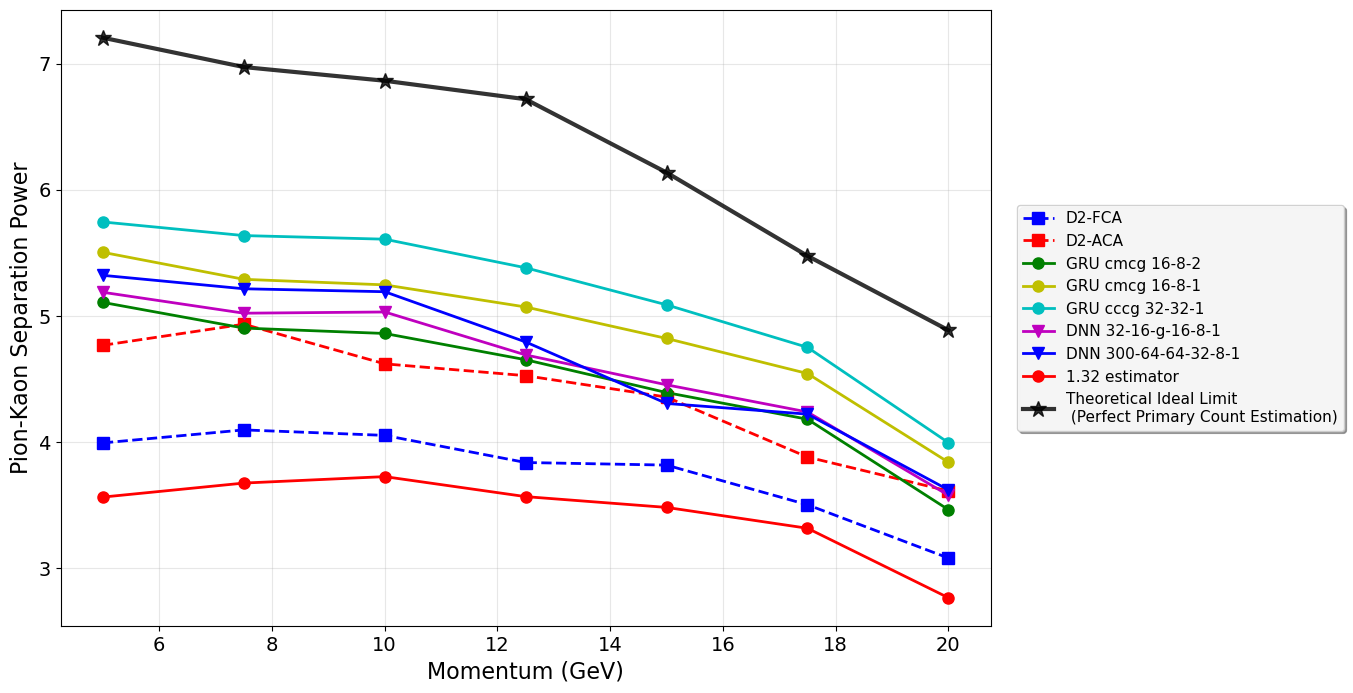

In [45]:
len_scaler = np.sqrt(1000/(9*np.sqrt(1)))
# len_scaler_l_old = 1000/(18*np.sqrt(2))

# Data preparation
kp_separation_FCA = [0.3788550456417212, 0.3886235160676578, 0.3844991594392201, 0.36409944875366457, 0.3621612305998233, 0.3323391850742314, 0.29229118560167483]
kp_separation_ACA = [0.4522474099362857, 0.4680811356448874, 0.438288641554179, 0.4293859427150638, 0.41330218919637196, 0.36821189790189696, 0.34267554228994834]
kp_separation_GRU_cmcg_16_8_2 = [0.48447178151106296, 0.46517322242059383, 0.46112123752067236, 0.4413745282944228, 0.4166951383291381, 0.3966553305136597, 0.32864849013333314]
kp_separation_GRU_cmcg_16_8_1 = [0.5221260915932282, 0.5018375292689825, 0.497661498040651, 0.48103475889345804, 0.45738246132683674, 0.431015959836475, 0.36433643808039506]
kp_separation_GRU_cccg_32_32_1 = [0.5449484013622283, 0.5347207268547595, 0.5320110540712728, 0.5105134155187305, 0.4826602672757581, 0.45069353099008713, 0.37904902502878046]
kp_separation_DNN_32_16_g_16_8_1 = [0.49208419896089634, 0.4763636114969396, 0.47727897819574844, 0.444989996379328, 0.42252294837090437, 0.402081549158546, 0.33948415202182897]
kp_separation_DNN_300_64_64_32_8_1 = [0.5048323584183317, 0.494727508358755, 0.4925120862447551, 0.45474941063415947, 0.4085065533034312, 0.4004786201099827, 0.34354397732174025]
kp_separation_DNN_64_32_32_8_1 = [0.48355733122264266, 0.4702436701880211, 0.46286066080542165, 0.4285133194332384, 0.3977340982758921, 0.3818169535115419, 0.32767516047745704]
kp_separation_132 = [0.33812139177988726, 0.34864443948540014, 0.3535007319189342, 0.3384538578203419, 0.3303485958833003, 0.31466675301469726, 0.26244565873596676]
kp_separation_ideal = [0.68347969, 0.66142709, 0.65113314, 0.63724259, 0.5821268, 0.51945814, 0.46358263]

# Apply scaling
data_sets = [
    kp_separation_FCA, kp_separation_ACA, kp_separation_GRU_cmcg_16_8_2,
    kp_separation_GRU_cmcg_16_8_1, kp_separation_GRU_cccg_32_32_1,
    kp_separation_DNN_32_16_g_16_8_1, kp_separation_DNN_300_64_64_32_8_1,
    kp_separation_DNN_64_32_32_8_1, kp_separation_132, kp_separation_ideal
]

for i, data in enumerate(data_sets):
    data_sets[i] = [value * len_scaler for value in data]

# Unpack scaled data
(kp_separation_FCA, kp_separation_ACA, kp_separation_GRU_cmcg_16_8_2,
 kp_separation_GRU_cmcg_16_8_1, kp_separation_GRU_cccg_32_32_1,
 kp_separation_DNN_32_16_g_16_8_1, kp_separation_DNN_300_64_64_32_8_1,
 kp_separation_DNN_64_32_32_8_1, kp_separation_132, kp_separation_ideal) = data_sets


fontsize_title = 18
fontsize_label = 16
fontsize_ticks = 14
fontsize_legend = 14

plt.figure(figsize=(12, 8))
plt.plot(pion_momenta, kp_separation_FCA, 'bs--', linewidth=2, markersize=8, label='D2-FCA')
plt.plot(pion_momenta, kp_separation_ACA, 'rs--', linewidth=2, markersize=8, label='D2-ACA')
plt.plot(pion_momenta, kp_separation_GRU_cmcg_16_8_2, 'go-', linewidth=2, markersize=8, label='GRU cmcg 16-8-2')
plt.plot(pion_momenta, kp_separation_GRU_cmcg_16_8_1, 'yo-', linewidth=2, markersize=8, label='GRU cmcg 16-8-1')
plt.plot(pion_momenta, kp_separation_GRU_cccg_32_32_1, 'co-', linewidth=2, markersize=8, label='GRU cccg 32-32-1')
plt.plot(pion_momenta, kp_separation_DNN_32_16_g_16_8_1, 'mv-', linewidth=2, markersize=8, label='DNN 32-16-g-16-8-1')
plt.plot(pion_momenta, kp_separation_DNN_300_64_64_32_8_1, 'bv-', linewidth=2, markersize=8, label='DNN 300-64-64-32-8-1')
plt.plot(pion_momenta, kp_separation_132, 'ro-', linewidth=2, markersize=8, label='1.32 estimator')
plt.plot(pion_momenta, kp_separation_ideal, 'k*-', linewidth=3, markersize=12, 
         label='Theoretical Ideal Limit \n (Perfect Primary Count Estimation)', alpha=0.8)
plt.xlabel('Momentum (GeV)', fontsize=fontsize_label)
plt.ylabel('Pion-Kaon Separation Power', fontsize=fontsize_label)
# plt.title('Pion-Kaon Separation Power', fontsize=fontsize_title)
plt.grid(True, alpha=0.3)
legend = plt.legend(fontsize=11, loc='center left', bbox_to_anchor=(1.02, 0.5), 
                   frameon=True, fancybox=True, shadow=True)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.9)
plt.xticks(fontsize=fontsize_ticks)
plt.yticks(fontsize=fontsize_ticks)
plt.show()